# Example 2: Cytotoxicity Contact Analysis

In this notebook we will demonstrate:
1. Convert segmented label data to sparse Pandas table
2. Use the label and sparse position table to return contact analysis across multiple frames
3. Remapping the cell feature table to ultrack results

In [1]:
from cyto.postprocessing.graph import *
from cyto.utils.label_to_table import *
import dask_image.imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
import pyclesperanto_prototype as cle
from skimage import exposure
import pandas as pd


## Load image files
pyCyto supports any image loader compatible with numpy/dask. Bioimages may storage in multiple formats and dimension orders. Here we load list of single image files under same directory with Dask Image, utilizing the lazy loading function to facilitate the pipeline optimization. For large dataset dask array is more preferable than numpy for better memory managements.

In [2]:
CANCER_IMAGE_PATH_PATTERN = "/media/Data2/Veronika/2023_02_08_Ashwin/Position4_KillingVesicles/BF/*.tif"

CANCER_LABEL_PATH_PATTERN = "/media/Data2/Veronika/2023_02_08_Ashwin/Position4_KillingVesicles/BF_masks/*.tif"

PI_IMAGE_PATH_PATTERN = "/media/Data2/Veronika/2023_02_08_Ashwin/Position4_KillingVesicles/PI/*.tif"

CASP_IMAGE_PATH_PATTERN = "/media/Data2/Veronika/2023_02_08_Ashwin/Position4_KillingVesicles/CaspG/*.tif"

In [3]:
# default chunk size: 1 image
image_cancer = dask_image.imread.imread(CANCER_IMAGE_PATH_PATTERN)

label_cancer = dask_image.imread.imread(CANCER_LABEL_PATH_PATTERN)

pi_image = dask_image.imread.imread(PI_IMAGE_PATH_PATTERN)

cancer_casp = dask_image.imread.imread(CASP_IMAGE_PATH_PATTERN)

image_cancer

dask.array<_map_read_frame, shape=(972, 994, 1004), dtype=uint16, chunksize=(1, 994, 1004), chunktype=numpy.ndarray>

Have a first glance of the images

Text(0.5, 1.0, 'Cancer Cell Labels')

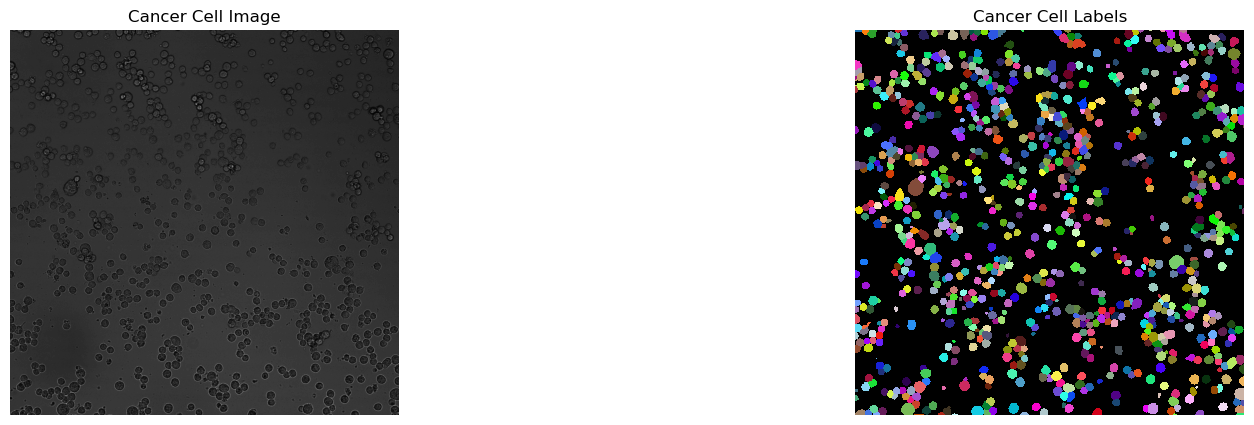

In [4]:
fig, axs = plt.subplots(1,2,figsize=(20,5))

axs[0].imshow(image_cancer[0,:,:],cmap="gray")
axs[0].set_axis_off()
axs[0].set_title("Cancer Cell Image")

cle.imshow(label_cancer[0,:,:], labels=True, plot=axs[1])
axs[1].set_axis_off()
axs[1].set_title("Cancer Cell Labels")



In [5]:
FRAMES = 971 #define number of frames

In [6]:
gamma_corr = exposure.adjust_gamma(pi_image[:FRAMES,:,:], gamma=0.5,gain=1)
percentile = 0.05
p2, p98 = np.percentile(gamma_corr.compute(), (percentile, 100-percentile))
Rescaled_gamma_pi = exposure.rescale_intensity(gamma_corr,in_range=(p2, p98))
Rescaled_gamma_pi = exposure.rescale_intensity(Rescaled_gamma_pi, in_range='uint16',out_range='uint8')

gamma_casp = exposure.adjust_gamma(cancer_casp[:FRAMES,:,:], gamma=0.5,gain=1)
percentile = 0.05
p2, p98 = np.percentile(gamma_casp.compute(), (percentile, 100-percentile))
Rescaled_gamma_casp = exposure.rescale_intensity(gamma_casp,in_range=(p2, p98))
Rescaled_gamma_casp = exposure.rescale_intensity(Rescaled_gamma_casp, in_range='uint16',out_range='uint8')

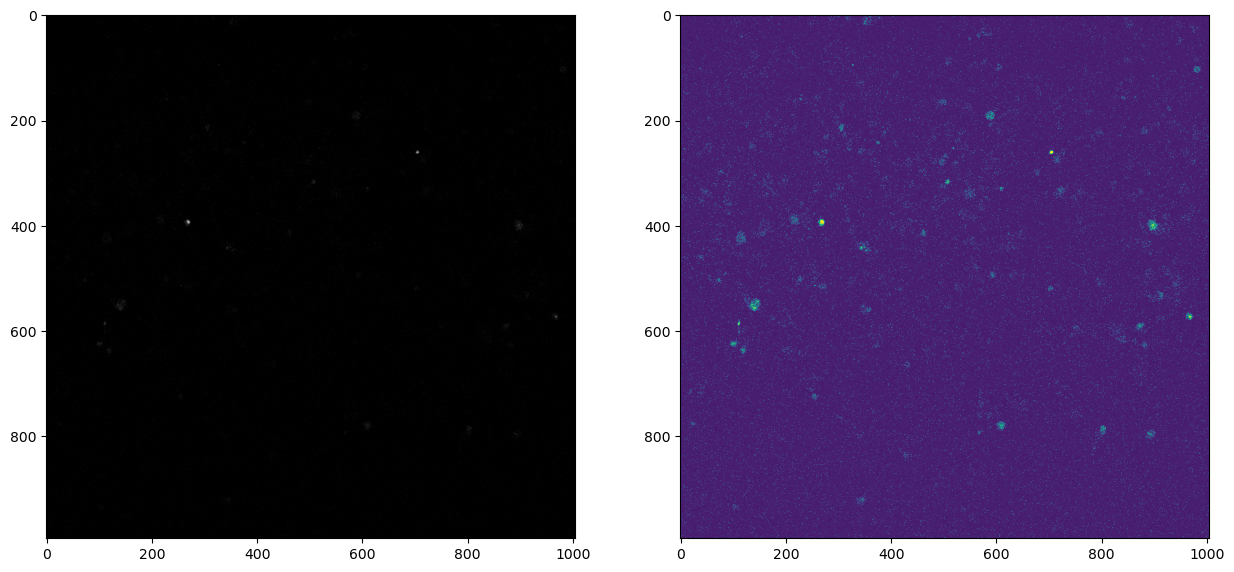

In [7]:
fig, ax = plt.subplots(1,2,figsize=[15,15])
ax[0].imshow(cancer_casp[0,:,:], cmap="gray")
ax[1].imshow(Rescaled_gamma_casp[0,:,:])

In [8]:
# convert segmentation mask to trackpy style array
features = {}
features_pi = {}
features_casp= {}

# note that pyCyto works in XYT dim order but dask/tiff is in TYX, need to transpose the array
# TODO: pixel spacing
features["cancer"] = label_to_sparse(label=label_cancer[:FRAMES,:,:].T,image=image_cancer[:FRAMES,:,:].T,spacing=[1,1],channel_name="cancer")

features_pi["cancer"] = label_to_sparse(label=label_cancer[:FRAMES,:,:].T,image=Rescaled_gamma_pi[:FRAMES,:,:].T,spacing=[1,1],channel_name="cancer_pi")

features_casp["cancer"] = label_to_sparse(label=label_cancer[:FRAMES,:,:].T,image=Rescaled_gamma_casp[:FRAMES,:,:].T,spacing=[1,1],channel_name="cancer_casp")



  0%|          | 0/971 [00:00<?, ?it/s]

100%|██████████| 971/971 [01:01<00:00, 15.78it/s] 


In [9]:
features["cancer"][["pi_mean","pi_median", "pi_std"]] = features_pi["cancer"][["mean","median", "sd"]] 
features["cancer"][["casp_mean","casp_median", "casp_std"]] = features_casp["cancer"][["mean","median", "sd"]] 

Regardless of the cell size and cluster formations, here we demonstrate how to purify the cell contact analysis table and generate relevant plots.

Here we load the original track file generated by ultrack 

In [10]:
# Load tracking file and merge with the contact analysis table
TRACK_PATH = "/media/Data2/Veronika/2023_02_08_Ashwin/Position4_KillingVesicles/tracks/tracks/tracks_param_00000.csv"

tracks_df = pd.read_csv(TRACK_PATH)
tracks_df = tracks_df.sort_values(by=["t"])
tracks_df = tracks_df[tracks_df["t"] < FRAMES]
tracks_df

,track_id,t,y,x,id,parent_track_id,parent_id
0,1,0,9.0,44.0,1000004,-1,-1
94961,395,0,496.0,553.0,1001024,-1,-1
178718,723,0,877.0,332.0,1001978,-1,-1
178759,724,0,893.0,330.0,1001980,-1,-1
94836,394,0,464.0,557.0,1001022,-1,-1
...,...,...,...,...,...,...,...
723852,13964,970,147.0,197.0,971000464,-1,970000443
724328,14018,970,844.0,241.0,971002023,-1,970002101
686443,12299,970,190.0,659.0,971000507,-1,970000488
719607,13695,970,685.0,854.0,971001372,-1,970001415


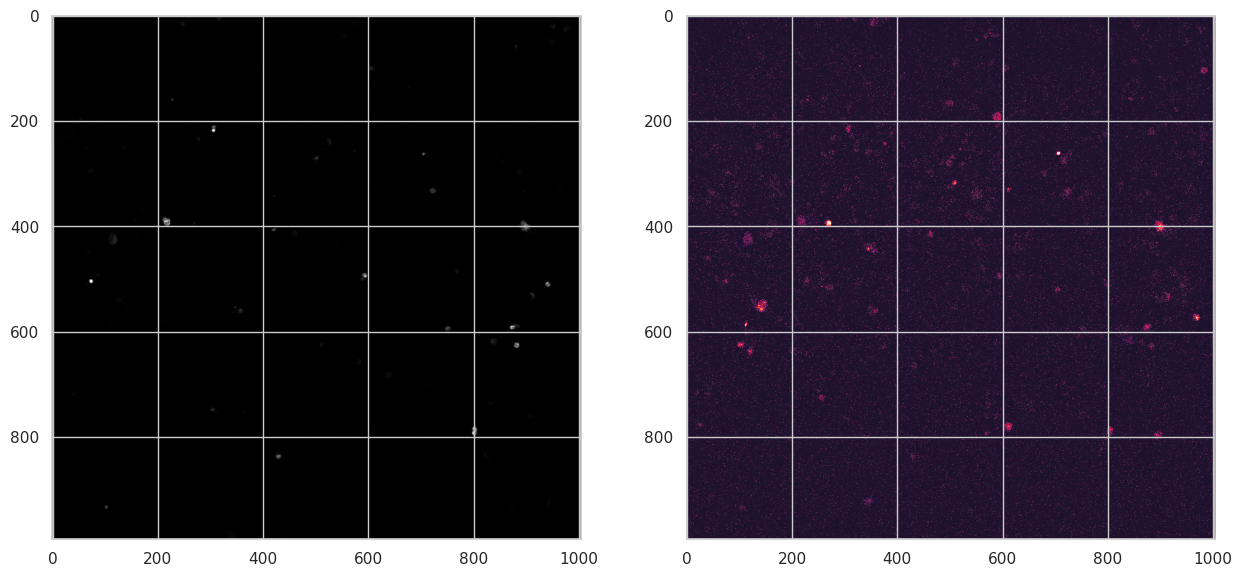

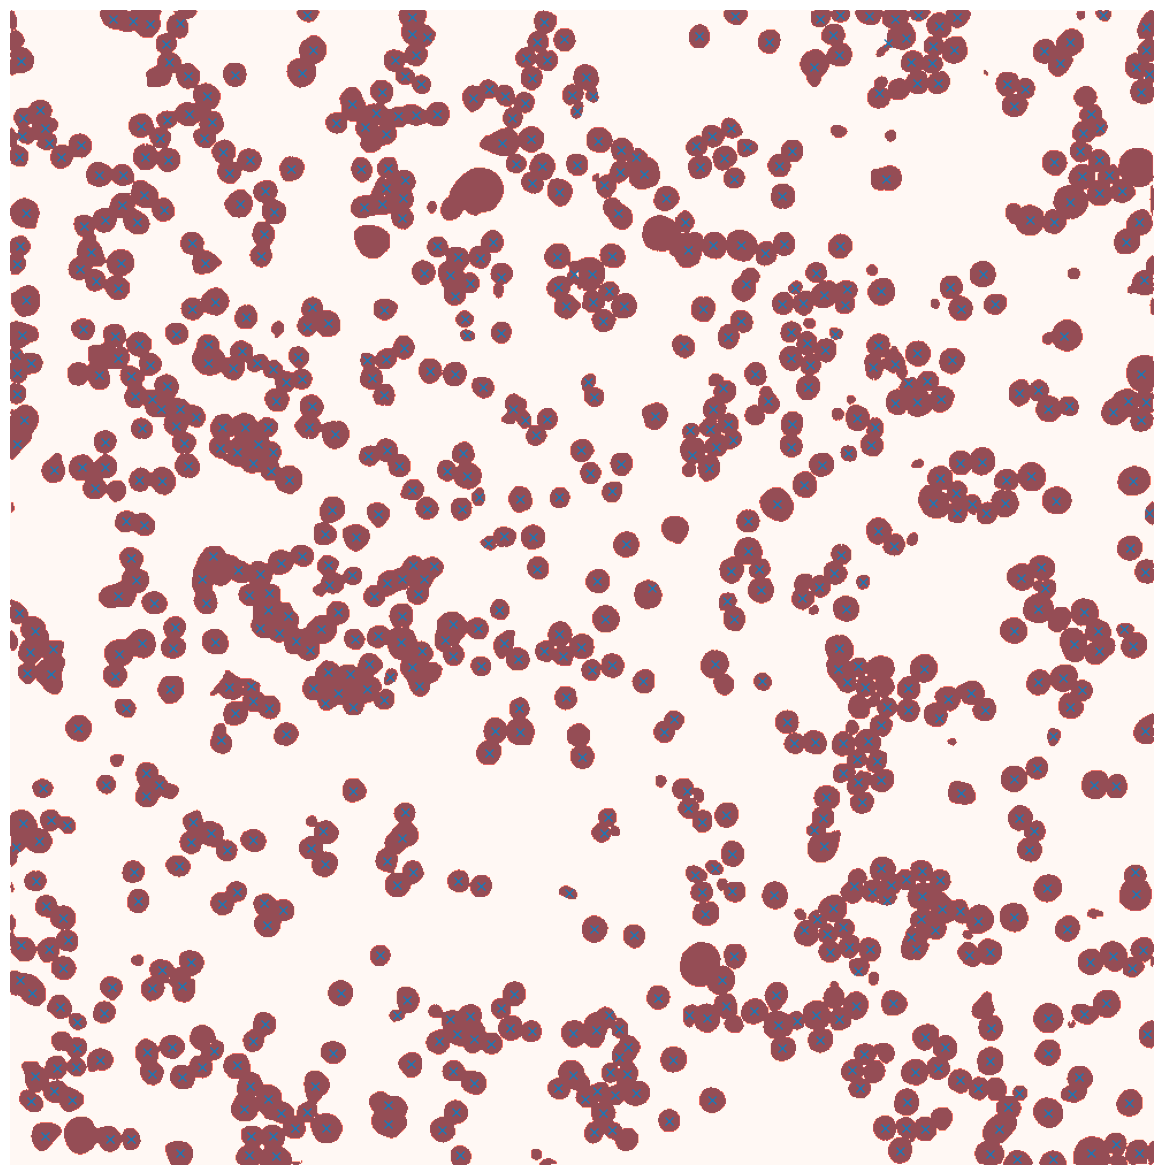

In [11]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
ax.set_axis_off()
frame = label_cancer[0,:,:].T
ax.imshow(exposure.rescale_intensity(frame, in_range=(0,1),out_range=(0,255)),cmap='Reds',alpha=0.7)
ax.plot(tracks_df[tracks_df.t==0].y,tracks_df[tracks_df.t==0].x,"x",label="Cancer Cells")

Ultrack reassigns the label ids, we need to remap back to the original segmentaiton ids by position matching

In [12]:
from sklearn.neighbors import KDTree

cancer_df = features["cancer"]

# iterate over frames
cancer_df_remapped = []
for t in range(FRAMES):
    cancer_t_df = cancer_df[cancer_df["frame"]==t]
    tracks_t_df = tracks_df[tracks_df["t"]==t]
    points_cancer = cancer_t_df[["y","x"]].values
    points_ultrack = tracks_t_df[["x","y"]].values

    # build KD-Tree for each point in ultrack df
    kdtree_ultrack = KDTree(points_ultrack)

    # query closest point for each point in t cell df
    dist, indices = kdtree_ultrack.query(points_cancer,k=1)

    dist = [d[0] for d in dist]
    indices = [i[0] for i in indices]

    remapped_track_ids = pd.DataFrame(tracks_t_df[["track_id","id"]].iloc[indices])
    remapped_track_ids["dist_from_ultrack"] = dist

    cancer_t_df.reset_index(drop=True,inplace=True)
    remapped_track_ids.reset_index(drop=True,inplace=True)
    cancer_t_df_remapped = pd.concat([cancer_t_df,remapped_track_ids],axis=1)

    cancer_df_remapped.append(cancer_t_df_remapped)

cancer_df_remapped = pd.concat(cancer_df_remapped)

track_pair_counts = cancer_df_remapped.groupby(["frame","track_id"]).size().reset_index(name="count")
filtered_rows = track_pair_counts[track_pair_counts['count'] != 1]

sorted_df_cancer = cancer_df_remapped.sort_values(by=["frame","track_id","dist_from_ultrack"])
sorted_df_cancer = sorted_df_cancer.drop_duplicates(subset=["frame","track_id"], keep="first")

sorted_df_cancer["tracked frames"] = sorted_df_cancer['frame'].groupby(sorted_df_cancer['track_id']).transform('count')
sorted_df_cancer['tracked length'] = sorted_df_cancer.groupby('track_id')['frame'].transform("max") - sorted_df_cancer.groupby('track_id')['frame'].transform("min") +1 

# filter out short tracks
min_track_length = 50
tracks_df_filtered_cancer = sorted_df_cancer[sorted_df_cancer["tracked length"] > min_track_length]

# filter by tracked average cell size
mean_transform = lambda x: x.mean()
tracks_df_filtered_cancer['mean tracked cell size'] = tracks_df_filtered_cancer.groupby("track_id")["size"].transform(mean_transform)

area_percentiles = tracks_df_filtered_cancer.sort_values("track_id")['mean tracked cell size'].quantile(0.95)

# filter out the cells with average area larger than threshold
tracks_df_filtered_cancer = tracks_df_filtered_cancer[tracks_df_filtered_cancer["mean tracked cell size"]<area_percentiles]
tracks_df_filtered_cancer

/tmp/ipykernel_1730365/1861482301.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df_filtered_cancer['mean tracked cell size'] = tracks_df_filtered_cancer.groupby("track_id")["size"].transform(mean_transform)


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,pi_std,casp_mean,casp_median,casp_std,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
774,775,115.132948,32.641618,23,107,18,15,32.641618,115.132948,23.0,...,6.229766,23.358382,21.0,13.939608,2,1000006,0.382247,168,169,219.547619
683,684,126.703704,7.456790,0,117,16,19,7.456790,126.703704,0.0,...,8.197759,23.485597,22.0,13.722260,3,1000009,0.544471,145,145,271.993103
461,462,102.156863,29.728758,19,93,23,21,29.728758,102.156863,19.0,...,6.759033,22.983660,22.0,10.943509,4,1000012,0.313334,314,318,289.652866
671,672,93.161943,11.263158,3,85,18,18,11.263158,93.161943,3.0,...,4.458787,22.477733,22.0,11.039034,5,1000013,0.308995,99,99,244.848485
552,553,86.441281,26.512456,16,78,21,18,26.512456,86.441281,16.0,...,5.313691,22.715302,21.0,12.127776,6,1000014,0.676269,144,150,276.986111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,844865,386.114014,709.876485,700,374,23,26,709.876485,386.114014,700.0,...,13.162642,22.489311,21.0,12.515819,13246,971001776,0.168093,53,53,414.566038
420,845044,312.005848,34.219298,25,300,23,27,34.219298,312.005848,25.0,...,8.232124,22.590643,21.0,13.787100,13253,971000182,0.219376,52,52,369.788462
684,845308,367.839779,989.348066,983,355,11,24,989.348066,367.839779,983.0,...,4.814216,23.845304,22.0,16.931179,13266,971002286,0.383172,52,53,197.326923
441,845065,792.849850,712.900901,702,782,22,21,712.900901,792.849850,702.0,...,21.317826,32.222222,21.0,36.305081,13284,971001439,0.179905,51,51,352.705882


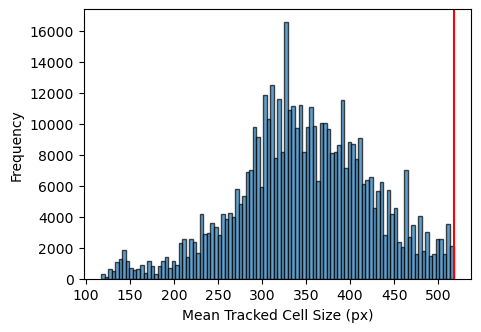

In [13]:
fig, axs = plt.subplots(1,1,figsize=(5,3.5))

tracks_df_filtered_cancer['mean tracked cell size'].plot(kind='hist', bins=100, edgecolor='black', alpha=0.7, ax=axs)
axs.set_xlabel("Mean Tracked Cell Size (px)")
axs.axvline(x=area_percentiles,c="r")

Save the remapped tracks dataframe

In [14]:
# save tracks
tracks_df_filtered_cancer.to_csv("/media/Data2/Veronika/2023_02_08_Ashwin/Position4_KillingVesicles/tracks/tracks/cancer_tracks_filtered.csv")

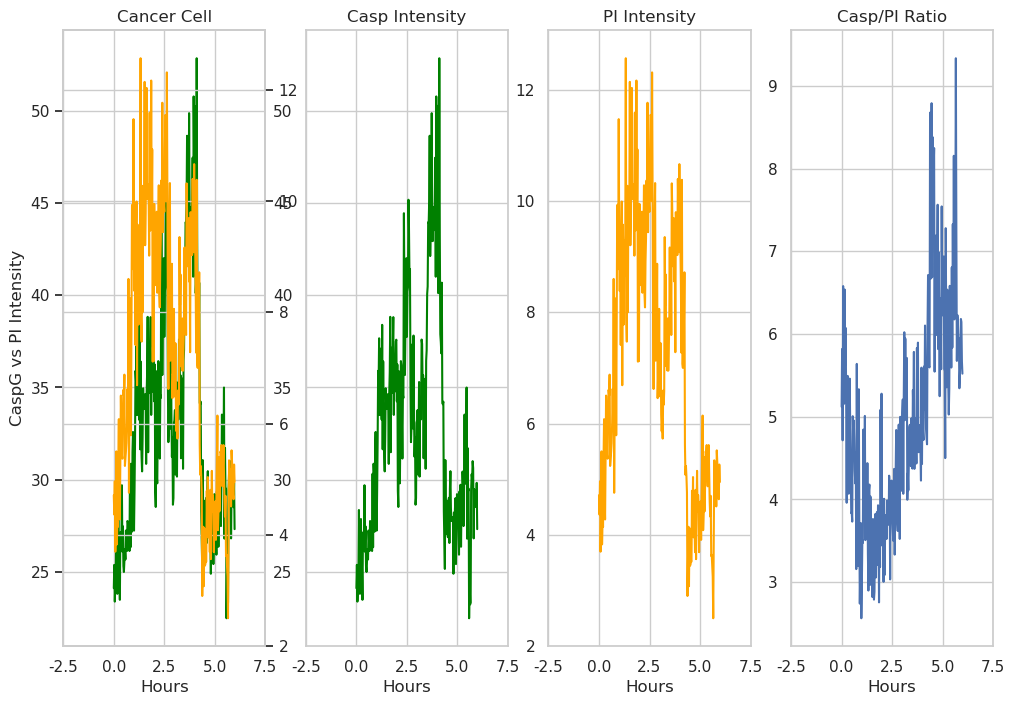

In [115]:
fig, axs = plt.subplots(1,4,figsize=(12,8), sharex=True)
axs=axs.ravel()

# isolate one cell
TRACK_ID_CANCER = 34

single_cancer_df = tracks_df_filtered_cancer.loc[tracks_df_filtered_cancer["track_id"]==TRACK_ID_CANCER]
single_cancer_df = single_cancer_df.sort_values(by=["frame"])

# cancer signal
axs[0].plot(single_cancer_df["frame"],single_cancer_df["casp_mean"],label="Casp", color="green")
axs_ = axs[0].twinx()
axs_.plot(single_cancer_df["frame"],single_cancer_df["pi_mean"],label="PI",color="orange")
axs[0].set_title("Cancer Cell")
axs[0].set_xlabel("Hours")
axs[0].set_ylabel("CaspG vs PI Intensity")
labels = axs_.get_xticks()
ticklabel = [t*1.5/60. for t in labels] #convert frames to real units for confocal data
axs_.set_xticks(labels, ticklabel)
#axs_.set_xlim([0,1000])

axs[1].plot(single_cancer_df["frame"],single_cancer_df["casp_mean"],color="green")
axs[1].set_title("Casp Intensity")
axs[1].set_xlabel("Hours")
labels = axs[1].get_xticks()
ticklabel = [t*1.5/60. for t in labels] 
axs[1].set_xticks(labels, ticklabel)
#axs[1].set_xlim([0,1000])
#axs[5].set_ylim([-1000,1000])

axs[2].plot(single_cancer_df["frame"],single_cancer_df["pi_mean"],color="orange")
axs[2].set_title("PI Intensity")
axs[2].set_xlabel("Hours")
labels = axs[2].get_xticks()
ticklabel = [t*1.5/60. for t in labels]
axs[2].set_xticks(labels, ticklabel)
#axs[2].set_xlim([0,1000])
#axs[5].set_ylim([-1000,1000])

axs[3].plot(single_cancer_df["frame"],single_cancer_df["casp_mean"]/single_cancer_df["pi_mean"])
axs[3].set_title("Casp/PI Ratio")
axs[3].set_xlabel("Hours")
labels = axs[3].get_xticks()
ticklabel = [t*1.5/60. for t in labels]
axs[3].set_xticks(labels, ticklabel)
#axs[3].set_xlim([0,1000])
#axs[4].set_ylim([0,5])

In [16]:
pd.set_option("display.max_columns", None)
single_cancer_df

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive,pi_mean,pi_median,pi_std,casp_mean,casp_median,casp_std,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
561,562,167.971326,323.508961,314,155,21,23,323.508961,167.971326,314.0,155.0,21.0,23.0,279.0,1.485430,1.485430,0.844667,25.806976,12.903488,70.100583,1090729.0,3909.422939,3771.414062,1392.155774,0,cancer,NaN,7.032258,0.0,12.663138,33.125448,23.0,29.391956,274,1000725,0.509768,238,240,354.840336
553,1434,168.753571,322.867857,312,158,22,21,322.867857,168.753571,312.0,158.0,22.0,21.0,280.0,1.515048,1.515048,0.862679,24.839485,12.419742,68.759824,1098630.0,3923.678571,3871.300781,1330.031580,1,cancer,NaN,6.417857,0.0,12.147556,30.100000,23.0,25.755064,274,2000758,1.158652,238,240,354.840336
267,2030,167.887324,322.647887,313,154,23,25,322.647887,167.887324,313.0,154.0,23.0,25.0,355.0,1.266506,1.266506,0.842729,27.658633,13.829317,79.255855,1365891.0,3847.580282,3633.001953,1496.029729,2,cancer,NaN,9.988732,0.0,15.308684,30.214085,23.0,27.288360,274,3000751,0.954635,238,240,354.840336
764,3411,170.755319,324.877660,318,162,16,17,324.877660,170.755319,318.0,162.0,16.0,17.0,188.0,1.218047,1.218047,0.887009,18.601075,9.300538,54.796878,739549.0,3933.771277,3763.119141,1562.667737,3,cancer,NaN,6.957447,0.0,12.694615,28.250000,22.0,23.388060,274,4000756,3.984057,238,240,354.840336
230,3756,167.189840,322.935829,314,149,22,32,322.935829,167.189840,314.0,149.0,22.0,32.0,374.0,1.612130,1.612130,0.761878,31.780497,15.890249,89.981923,1361935.0,3641.537433,3392.072266,1564.980423,4,cancer,NaN,12.171123,0.0,16.613816,30.085561,23.0,26.607527,274,5000778,0.200392,238,240,354.840336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,204462,161.723856,323.300654,308,148,32,28,323.300654,161.723856,308.0,148.0,32.0,28.0,612.0,1.535541,1.535541,0.918860,34.058773,17.029386,95.440242,2332369.0,3811.060458,3919.437500,1116.403048,235,cancer,NaN,13.429739,0.0,19.882551,26.197712,23.0,19.966382,274,236000787,0.408225,238,240,354.840336
147,205436,158.976415,319.525943,307,148,29,24,319.525943,158.976415,307.0,148.0,29.0,24.0,424.0,1.423752,1.423752,0.885878,28.284271,14.142136,82.397447,1591393.0,3753.285377,3766.042969,1274.479363,236,cancer,NaN,16.853774,0.0,22.013908,29.035377,22.0,25.555135,274,237000810,4.020443,238,240,354.840336
197,206338,160.341772,317.078481,306,149,25,24,317.078481,160.341772,306.0,149.0,25.0,24.0,395.0,1.206338,1.206338,0.914574,25.000000,12.500000,77.034413,1459909.0,3695.972152,3713.796875,1222.246568,237,cancer,NaN,15.622785,0.0,21.889014,28.992405,22.0,27.325402,274,238000783,5.193368,238,240,354.840336
192,207191,160.866005,317.513648,306,148,25,26,317.513648,160.866005,306.0,148.0,25.0,26.0,403.0,1.226354,1.226354,0.892714,27.313001,13.656500,79.715930,1490211.0,3697.794045,3786.835938,1098.665079,238,cancer,NaN,17.153846,0.0,23.210719,29.297767,23.0,25.959702,274,239000787,4.968027,238,240,354.840336


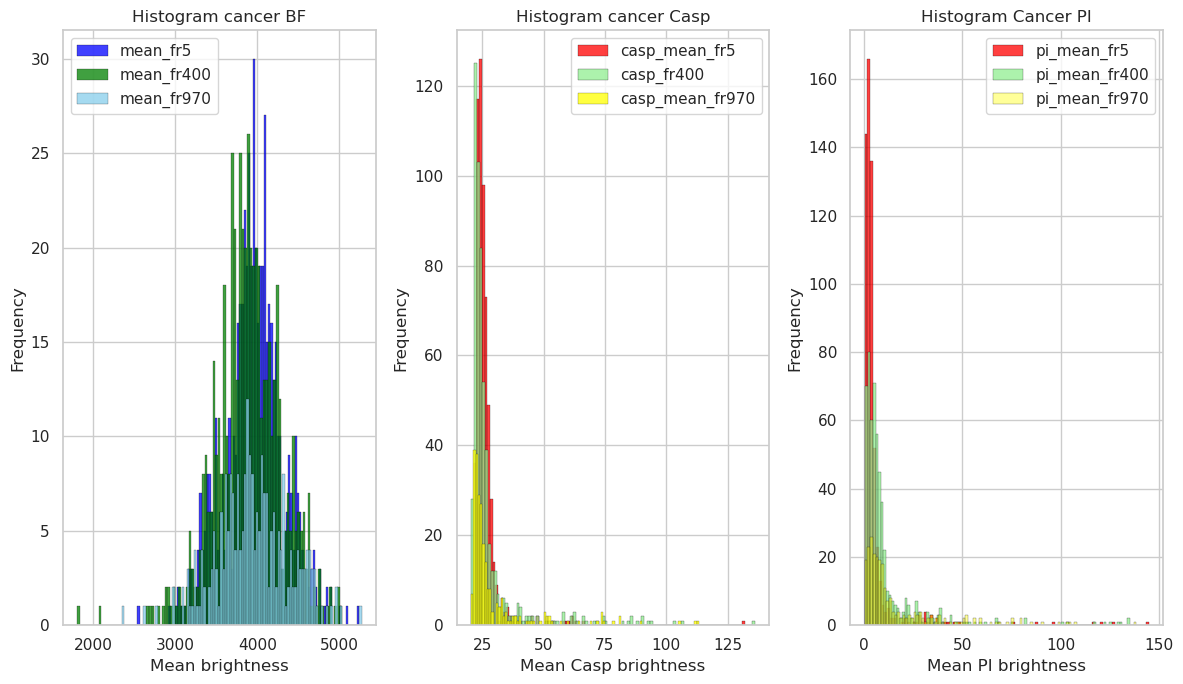

In [44]:
import seaborn as sns

# Set Seaborn style
sns.set(style='whitegrid')

tracks_df_filtered_cancer_bright_5 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==5]
tracks_df_filtered_cancer_bright_400 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==400]
tracks_df_filtered_cancer_bright_970 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==970]

tracks_df_filtered_cancer_casp_5 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==5]
tracks_df_filtered_cancer_casp_400 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==400]
tracks_df_filtered_cancer_casp_970 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==970]

tracks_df_filtered_cancer_pi_5 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==5]
tracks_df_filtered_cancer_pi_400 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==400]
tracks_df_filtered_cancer_pi_970 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==970]

#### Plot cancer histogram
fig, axes = plt.subplots(1, 3, figsize=(12, 7))
axes = axes.flatten()
sns.histplot(data=tracks_df_filtered_cancer_bright_5, x='mean', bins=100, kde=False, color='blue', edgecolor='black', label='mean_fr5', ax=axes[0])
sns.histplot(data=tracks_df_filtered_cancer_bright_400, x='mean', bins=100, kde=False, color='green', edgecolor='black', label='mean_fr400', ax=axes[0])
sns.histplot(data=tracks_df_filtered_cancer_bright_970, x='mean', bins=100, kde=False, color='skyblue', edgecolor='black', label='mean_fr970', ax=axes[0])
axes[0].set_title('Histogram cancer BF')
axes[0].set_xlabel("Mean brightness")
axes[0].set_ylabel("Frequency")
#axes[0].set_yscale("log")
axes[0].legend()

# Plot a histogram
sns.histplot(data=tracks_df_filtered_cancer_casp_5, x='casp_mean', bins=100, kde=False, color='red', edgecolor='black', label='casp_mean_fr5', ax=axes[1])
sns.histplot(data=tracks_df_filtered_cancer_casp_400, x='casp_mean', bins=100, kde=False, color='lightgreen', edgecolor='black', label='casp_mean_fr400', ax=axes[1])
sns.histplot(data=tracks_df_filtered_cancer_casp_970, x='casp_mean', bins=100, kde=False, color='yellow', edgecolor='black', label='casp_mean_fr970', ax=axes[1])
axes[1].set_title('Histogram cancer Casp')
axes[1].set_xlabel("Mean Casp brightness")
axes[1].set_ylabel("Frequency")
#axes[1].set_yscale("log")
axes[1].legend()

# Plot a histogram
sns.histplot(data=tracks_df_filtered_cancer_pi_5, x='pi_mean', bins=100, kde=False, color='red', edgecolor='black', ax=axes[2],label='pi_mean_fr5')
sns.histplot(data=tracks_df_filtered_cancer_pi_400, x='pi_mean', bins=100, kde=False, color='lightgreen', edgecolor='black', ax=axes[2],label='pi_mean_fr400')
sns.histplot(data=tracks_df_filtered_cancer_pi_970, x='pi_mean', bins=100, kde=False, color="yellow", edgecolor='black', ax=axes[2], label='pi_mean_fr970', alpha=0.4)
axes[2].set_title('Histogram Cancer PI')
axes[2].set_xlabel("Mean PI brightness")
axes[2].set_ylabel("Frequency")
#axes[2].set_xscale("log")
#axes[2].set_yscale("log")
#axes[2].set_xlim([32000,44000])
axes[2].legend()



plt.tight_layout()